In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from skest import *
import scipy
import time
from signals import *

#### test codes

In [3]:
G = nx.barbell_graph(5, 10)

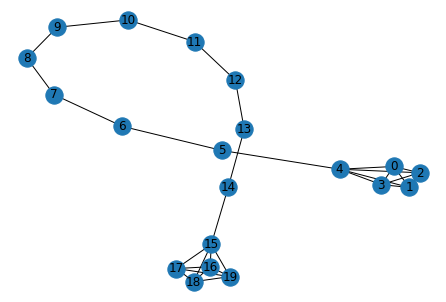

In [5]:
nx.draw(G, with_labels = True)

<AxesSubplot:>

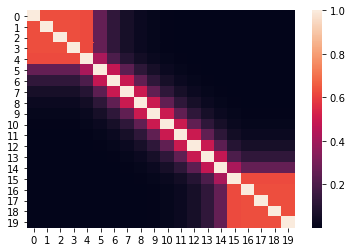

In [8]:
import seaborn as sb
sb.heatmap(cor_from_G(G, 0.5))

In [19]:
def barbell_signal(m1, m2, start_value, height):
    b = np.zeros(2*m1 + m2)
    b[0:m1] = start_value*np.ones(m1)
    b[m1+m2:2*m1 + m2] = (start_value + height) * np.ones(m1)
    if m2 > 0:
        c = m2+1
        path = [height/2 + height/2 * np.sin(j * np.pi/c) for j in np.arange(-c/2+1, c/2, 1)] 
        path = [x + start_value for x in path]
        b[m1:m1+m2] = np.array(path)
    return b

In [21]:
barbell_signal(2, 3, 5, 5)

array([ 5.        ,  5.        ,  5.73223305,  7.5       ,  9.26776695,
       10.        , 10.        ])

In [22]:
def D_from_G(G):
    return np.asarray(nx.incidence_matrix(G, oriented = True).T.todense())

### fix $\sigma = 3$,  $\beta_j = 5$ on first cluster, and $\beta_j = 20$ on the second cluster

### a) signal 1  m1 = 30 m2 = 0, p = 60, p/n = 1.5 

In [215]:
sigma = 3

In [216]:
m1 = 30
m2 = 0
n = 40
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)


In [217]:
print(naive_cv(OUR, X,y, D))

({'l1': 1, 'l2': 0}, 13.48874044418335)


In [218]:
print(naive_cv(FL, X, y, D))
print(naive_cv(SL, X, y, D))

({'l1': 0, 'l2': 1}, 10.10504150390625)
({'l1': 0, 'l2': 3}, 9.823486804962158)


In [219]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 1, D).fit(X, y)
    clf2 = SL(0, 3, D).fit(X,y)
    clf3 = OUR(1, 0, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]

In [220]:
from joblib import Parallel, delayed
import multiprocessing

In [221]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))

In [222]:
def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 1, D).fit(X, y)
    clf2 = SL(0, 3, D).fit(X,y)
    clf3 = OUR(1, 0, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [223]:
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [224]:
ap1 = [l[0] for l in preds]
ap2 = [l[1] for l in preds]
ap3 = [l[2] for l in preds]

{'whiskers': [<matplotlib.lines.Line2D at 0x239ff8ab040>,
 'caps': [<matplotlib.lines.Line2D at 0x239ff9fa7f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x239fcf9de20>,
 'medians': [<matplotlib.lines.Line2D at 0x239ff6bedc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x239ff6be550>,
 'means': []}

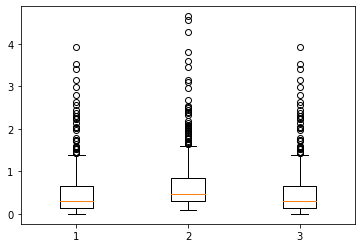

In [225]:
plt.boxplot([ap1,ap2,ap3])

In [78]:
ar1 = [l[0] for l in l2s]
ar2 = [l[1] for l in l2s]
ar3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239fce9d9d0>,
 'caps': [<matplotlib.lines.Line2D at 0x239fcea4400>,
 'boxes': [<matplotlib.lines.Line2D at 0x239fce9d1c0>,
 'medians': [<matplotlib.lines.Line2D at 0x239fcea4ac0>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fcea4e20>,
 'means': []}

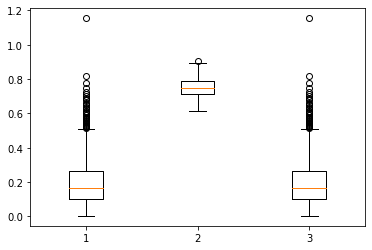

In [79]:
plt.boxplot([ar1,ar2,ar3])

### b) signal 2  m1 = 30 m2 = 3, p = 63, p/n ~ 1.5 , n = 42

In [255]:
m1 = 30
m2 = 3
n = 42
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)

In [256]:
print(naive_cv(OUR, X,y, D))
print(naive_cv(FL, X, y, D))
print(naive_cv(SL, X, y, D))

({'l1': 7.5, 'l2': 0.5}, 13.306856870651245)
({'l1': 0, 'l2': 1}, 11.227854251861572)
({'l1': 0, 'l2': 1}, 10.338421106338501)


In [257]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 1, D).fit(X, y)
    clf2 = SL(0, 1, D).fit(X,y)
    clf3 = OUR(7.5, 0.5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]

In [258]:
def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 1, D).fit(X, y)
    clf2 = SL(0, 1, D).fit(X,y)
    clf3 = OUR(7.5, 0.5, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [259]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))

In [260]:
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))

In [261]:
bp1 = [l[0] for l in preds]
bp2 = [l[1] for l in preds]
bp3 = [l[2] for l in preds]

In [262]:
br1 = [l[0] for l in l2s]
br2 = [l[1] for l in l2s]
br3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239ffeda700>,
 'caps': [<matplotlib.lines.Line2D at 0x23986298e80>,
 'boxes': [<matplotlib.lines.Line2D at 0x239ff90ecd0>,
 'medians': [<matplotlib.lines.Line2D at 0x239ffec3fd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x23986464c10>,
 'means': []}

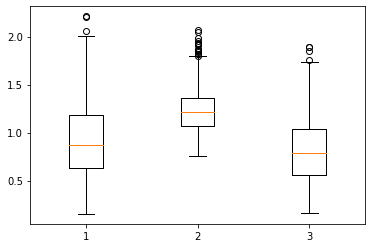

In [263]:
plt.boxplot([br1,br2,br3])

In [127]:
np.mean(br1)

0.9734813748697484

In [128]:
np.mean(br3)

0.9037646609552173

### c) signal 3  m1 = 30 m2 = 6, p = 66, p/n ~ 1.5 , n = 44

In [133]:
m1 = 30
m2 = 6
n = 44
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)

In [134]:

print(naive_cv_large(OUR, X,y, D))
print(naive_cv_large(FL, X, y, D))
print(naive_cv_large(SL, X, y, D))

({'l1': 1, 'l2': 5}, 34.0071907043457)
({'l1': 1, 'l2': 2}, 18.425657749176025)
({'l1': 0, 'l2': 7.5}, 19.026660442352295)


In [135]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(1, 2, D).fit(X, y)
    clf2 = SL(0, 7.5, D).fit(X,y)
    clf3 = OUR(1, 5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]
def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(1, 2, D).fit(X, y)
    clf2 = SL(0, 7.5, D).fit(X,y)
    clf3 = OUR(1, 5, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [136]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))
cp1 = [l[0] for l in preds]
cp2 = [l[1] for l in preds]
cp3 = [l[2] for l in preds]
cr1 = [l[0] for l in l2s]
cr2 = [l[1] for l in l2s]
cr3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239fd14ad90>,
 'caps': [<matplotlib.lines.Line2D at 0x239fb9fd670>,
 'boxes': [<matplotlib.lines.Line2D at 0x239fd0d2640>,
 'medians': [<matplotlib.lines.Line2D at 0x239fcfd2850>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fcfd2310>,
 'means': []}

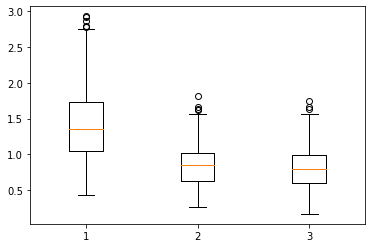

In [137]:
plt.boxplot([cr1,cr2,cr3])

### d) signal4  m1 = 30 m2 = 9, p = 69, p/n ~ 1.5 , n = 46

In [145]:
m1 = 30
m2 = 9
n = 46
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)

In [146]:
print(naive_cv_large(OUR, X,y, D))
print(naive_cv_large(FL, X, y, D))
print(naive_cv_large(SL, X, y, D))

({'l1': 100, 'l2': 7.5}, 31.193965435028076)
({'l1': 0, 'l2': 100}, 19.099288940429688)
({'l1': 0, 'l2': 7.5}, 19.30748724937439)


In [147]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 100, D).fit(X, y)
    clf2 = SL(0, 7.5, D).fit(X,y)
    clf3 = OUR(100, 7.5, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]

def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 100, D).fit(X, y)
    clf2 = SL(0, 7.5, D).fit(X,y)
    clf3 = OUR(100, 7.5, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [149]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))
dp1 = [l[0] for l in preds]
dp2 = [l[1] for l in preds]
dp3 = [l[2] for l in preds]
dr1 = [l[0] for l in l2s]
dr2 = [l[1] for l in l2s]
dr3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239fcdb0850>,
 'caps': [<matplotlib.lines.Line2D at 0x239fd2b7fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x239fcdb0f70>,
 'medians': [<matplotlib.lines.Line2D at 0x239fd2b7040>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fcdd8f10>,
 'means': []}

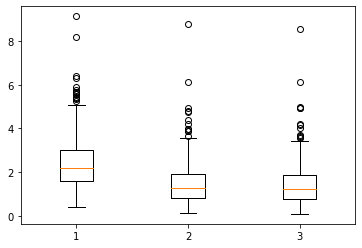

In [150]:
plt.boxplot([dp1,dp2,dp3])


In [152]:
print(np.mean(dr2), np.mean(dr3))

0.8367872897184534 0.815546073731324


### e) signal5  m1 = 30 m2 = 12, p = 69, p/n ~ 1.5 , n = 48

In [191]:
m1 = 30
m2 = 12
n = 48
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)

In [192]:

print(naive_cv_large(OUR, X,y, D))
print(naive_cv_large(FL, X, y, D))
print(naive_cv_large(SL, X, y, D))

({'l1': 0.5, 'l2': 20}, 36.2252631187439)
({'l1': 0, 'l2': 5}, 19.407724618911743)
({'l1': 2, 'l2': 15}, 19.957002878189087)


In [193]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 5, D).fit(X, y)
    clf2 = SL(2, 15, D).fit(X,y)
    clf3 = OUR(0.5, 20, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]

def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(0, 5, D).fit(X, y)
    clf2 = SL(2, 15, D).fit(X,y)
    clf3 = OUR(0.5, 20, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [194]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))
ep1 = [l[0] for l in preds]
ep2 = [l[1] for l in preds]
ep3 = [l[2] for l in preds]
er1 = [l[0] for l in l2s]
er2 = [l[1] for l in l2s]
er3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239fd25f970>,
 'caps': [<matplotlib.lines.Line2D at 0x239fd288460>,
 'boxes': [<matplotlib.lines.Line2D at 0x239ff4eabb0>,
 'medians': [<matplotlib.lines.Line2D at 0x239ff6bc850>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fcf9d760>,
 'means': []}

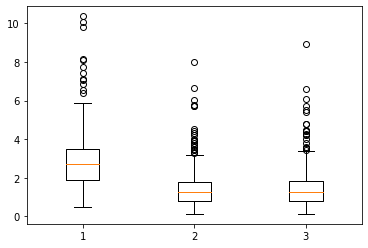

In [195]:
plt.boxplot([ep1,ep2,ep3])

{'whiskers': [<matplotlib.lines.Line2D at 0x239ff7a4610>,
 'caps': [<matplotlib.lines.Line2D at 0x239ff7a4ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x239ff7a42b0>,
 'medians': [<matplotlib.lines.Line2D at 0x239ff7ae220>,
 'fliers': [<matplotlib.lines.Line2D at 0x239ff7ae580>,
 'means': []}

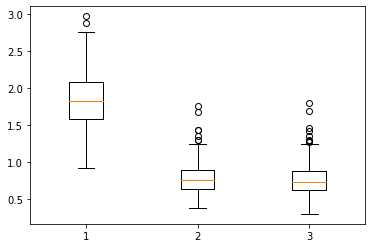

In [196]:
plt.boxplot([er1,er2,er3])

### f) signal6  m1 = 30 m2 = 15, p = 75, p/n ~ 1.5 , n = 50

In [176]:
m1 = 30
m2 = 15
n = 50
G = nx.barbell_graph(m1, m2)
Psi = cor_from_G(G, 0.5)
D = D_from_G(G)
beta_star = barbell_signal(m1, m2, 5, 15)
X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)

In [177]:
print(naive_cv_large(OUR, X,y, D))
print(naive_cv_large(FL, X, y, D))
print(naive_cv_large(SL, X, y, D))

({'l1': 125, 'l2': 25}, 29.69252848625183)
({'l1': 2, 'l2': 7.5}, 20.029683589935303)
({'l1': 0, 'l2': 25}, 22.014747142791748)


In [178]:
def trial1():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(2, 7.5, D).fit(X, y)
    clf2 = SL(0, 25, D).fit(X,y)
    clf3 = OUR(125, 25, D).fit(X,y)
    return [c.l2_risk(beta_star) for c in [clf1, clf2, clf3]]

def trial2():
    X, y = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    clf1 = FL(2, 7.5, D).fit(X, y)
    clf2 = SL(0, 25, D).fit(X,y)
    clf3 = OUR(125, 25, D).fit(X,y)
    X2, y2 = gauss_sample(n, 2*m1 + m2, beta_star, Psi, sigma)
    return [-c.score(X2, X2@beta_star) for c in [clf1, clf2, clf3]]

In [179]:
l2s = Parallel(n_jobs=8)(delayed(trial1)() for i in range(500))
preds = Parallel(n_jobs=8)(delayed(trial2)() for i in range(500))
fp1 = [l[0] for l in preds]
fp2 = [l[1] for l in preds]
fp3 = [l[2] for l in preds]
fr1 = [l[0] for l in l2s]
fr2 = [l[1] for l in l2s]
fr3 = [l[2] for l in l2s]

{'whiskers': [<matplotlib.lines.Line2D at 0x239ff4840a0>,
 'caps': [<matplotlib.lines.Line2D at 0x239ff4105b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x239ff3ed460>,
 'medians': [<matplotlib.lines.Line2D at 0x239fd26a400>,
 'fliers': [<matplotlib.lines.Line2D at 0x239fd26a340>,
 'means': []}

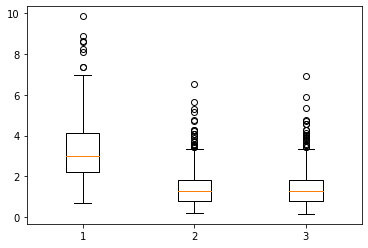

In [180]:
plt.boxplot([fp1,fp2,fp3])

In [185]:
import numpy.linalg as la

In [264]:
FL_risk_med = [np.median(r) for r in [ar1, br1, cr1, dr1, er1, fr1]]

In [265]:
FL_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar1, br1, cr1, dr1, er1, fr1]], [np.quantile(r, 0.75) - np.median(r) for r in [ar1, br1, cr1, dr1, er1, fr1]]]

<ErrorbarContainer object of 3 artists>

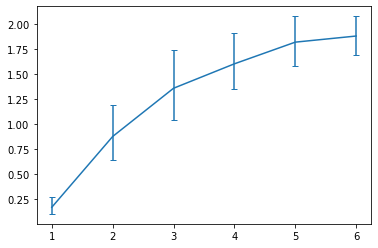

In [266]:
plt.errorbar(range(1, 7), FL_risk_med, yerr = FL_risk_err, capsize = 3)

In [267]:
SL_risk_med = [np.median(r) for r in [ar2, br2, cr2, dr2, er2, fr2]]
SL_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar2, br2, cr2, dr2, er2, fr2]], [np.quantile(r, 0.75) - np.median(r) for r in [ar2, br2, cr2, dr2, er2, fr2]]]

<ErrorbarContainer object of 3 artists>

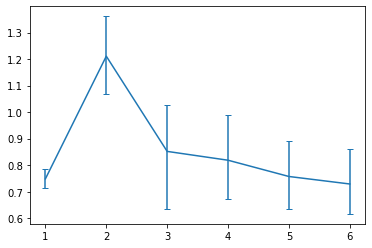

In [268]:
plt.errorbar(range(1, 7), SL_risk_med, yerr = SL_risk_err, capsize = 3)

In [269]:
GEE_risk_med = [np.median(r) for r in [ar3, br3, cr3, dr3, er3, fr3]]
GEE_risk_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ar3, br3, cr3, dr3, er3, fr3]], [np.quantile(r, 0.75) - np.median(r) for r in [ar3, br3, cr3, dr3, er3, fr3]]]

<ErrorbarContainer object of 3 artists>

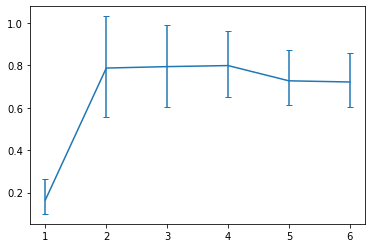

In [270]:
plt.errorbar(range(1, 7), GEE_risk_med, yerr = GEE_risk_err, capsize = 3)

In [236]:
Ds = [D_from_G(nx.barbell_graph(30, m)) for m in [0, 3, 6, 9, 12, 15]]

In [237]:
bs = [barbell_signal(30, m, 5, 15) for m in [0, 3, 6, 9, 12, 15]]

In [238]:
edge_smoothness = [la.norm(Ds[i]@bs[i]) for i in range(6)]

In [241]:
Gamma_infty = [la.norm(Ds[i] @bs[i], ord = np.inf) for i in range(6)]

In [242]:
import matplotlib as mpl

In [243]:
x1s_ticks = [str(round(l,2)) for l in Gamma_infty]
x2s_ticks = [str(round(e,2)) for e in edge_smoothness]

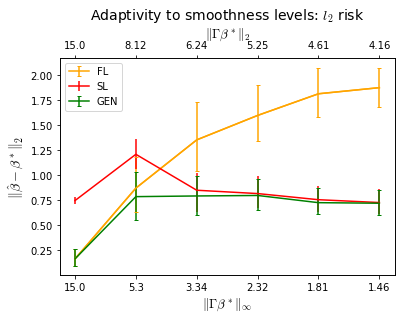

In [277]:
mpl.rcParams['mathtext.fontset'] = 'cm'

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax2.set_xlabel(r"$\|\Gamma \beta^*\|_2$", size = 13)
ax1.set_xlabel(r'$\|\Gamma \beta^*\|_\infty$', size = 13)
ax1.plot(x1s_ticks,FL_risk_med, color = 'orange')
ax2.errorbar(x2s_ticks, FL_risk_med, yerr = FL_risk_err, capsize = 2, color = 'orange', label = "FL")
ax2.errorbar(x2s_ticks, SL_risk_med, yerr = SL_risk_err, color = 'red', label = "SL")
ax2.errorbar(x2s_ticks, GEE_risk_med, yerr = GEE_risk_err, capsize = 2, color = 'green', label = "GEN")
ax1.set_ylabel(r'$\| \hat{\beta} - \beta^*\|_2$', size = 14)
plt.legend()
plt.title(r"Adaptivity to smoothness levels: $l_2$ risk", size = 14)
fig.savefig('152a.jpg', bbox_inches='tight', dpi = 600)

In [272]:
FL_pred_med = [np.median(r) for r in [ap1, bp1, cp1, dp1, ep1, fp1]]
FL_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap1, bp1, cp1, dp1, ep1, fp1]], [np.quantile(r, 0.75) - np.median(r) for r in [ap1, bp1, cp1, dp1, ep1, fp1]]]

In [273]:
SL_pred_med = [np.median(r) for r in [ap2, bp2, cp2, dp2, ep2, fp2]]
SL_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap2, bp2, cp2, dp2, ep2, fp2]], [np.quantile(r, 0.75) - np.median(r) for r in [ap2, bp2, cp2, dp2, ep2, fp2]]]

In [274]:
GEE_pred_med = [np.median(r) for r in [ap3, bp3, cp3, dp3, ep3, fp3]]
GEE_pred_err = [[np.median(r) - np.quantile(r, 0.25) for r in [ap3, bp3, cp3, dp3, ep3, fp3]], [np.quantile(r, 0.75) - np.median(r) for r in [ap3, bp3, cp3, dp3, ep3, fp3]]]

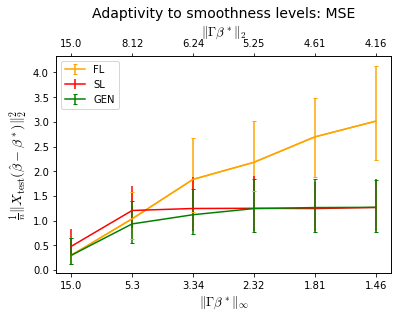

In [279]:
mpl.rcParams['mathtext.fontset'] = 'cm'

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()
ax2.set_xlabel(r"$\|\Gamma \beta^*\|_2$", size = 13)
ax1.set_xlabel(r'$\|\Gamma \beta^*\|_\infty$', size = 13)
ax1.plot(x1s_ticks,FL_pred_med, color = 'orange')
ax2.errorbar(x2s_ticks, FL_pred_med, yerr = FL_pred_err, capsize = 2, color = 'orange', label = "FL")
ax2.errorbar(x2s_ticks, SL_pred_med, yerr = SL_pred_err, color = 'red', label = "SL")
ax2.errorbar(x2s_ticks, GEE_pred_med, yerr = GEE_pred_err, capsize = 2, color = 'green', label = "GEN")
ax1.set_ylabel(r'$\frac{1}{n}\| X_{\mathrm{test}}(\hat{\beta} - \beta^*)\|_2^2$', size = 14)
plt.legend()
plt.title("Adaptivity to smoothness levels: MSE", size = 14)
fig.savefig('152b.jpg', bbox_inches='tight', dpi = 600)